# Packages Preparation

In [ ]:
!pip install Sastrawi
!pip install wordcloud==1.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp310-cp310-linux_x86_64.whl size=402046 sha256=cdaa477eb01469e08e2df7fdbb4728d0b8b94e5968d36a647606db3b797c6c7f
  Stored in directory: /root/.cache/pip/wheels/6b/b1/75/024072f28a2b9d6c4f80b35ebfd6ced7fd9fc58e9f1b933b9f
Successfully built wordcloud
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.9.3
    Uninstalling wordcloud-1.9.3:
      Successfully uninstalled wordcloud-1.9.3


In [ ]:
import string
import re
import pathlib
import json
import pickle

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from wordcloud import WordCloud, STOPWORDS

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, regularizers, layers, optimizers, losses, initializers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Import Data

https://www.kaggle.com/datasets/ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text

In [ ]:
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text
!unzip /content/indonesian-abusive-and-hate-speech-twitter-text.zip -d /content/

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text
License(s): CC-BY-NC-SA-4.0
100% 814k/814k [00:00<00:00, 920kB/s]
100% 814k/814k [00:00<00:00, 920kB/s]
Archive:  /content/indonesian-abusive-and-hate-speech-twitter-text.zip
  inflating: /content/README.md      
  inflating: /content/abusive.csv    
  inflating: /content/citation.bib   
  inflating: /content/data.csv       
  inflating: /content/new_kamusalay.csv  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

In [ ]:
df = pd.read_csv('/content/data.csv', encoding='latin-1')
df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13169 non-null  object
 1   HS             13169 non-null  int64 
 2   Abusive        13169 non-null  int64 
 3   HS_Individual  13169 non-null  int64 
 4   HS_Group       13169 non-null  int64 
 5   HS_Religion    13169 non-null  int64 
 6   HS_Race        13169 non-null  int64 
 7   HS_Physical    13169 non-null  int64 
 8   HS_Gender      13169 non-null  int64 
 9   HS_Other       13169 non-null  int64 
 10  HS_Weak        13169 non-null  int64 
 11  HS_Moderate    13169 non-null  int64 
 12  HS_Strong      13169 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.3+ MB


# Data Cleansing

## Duplicated Data

Number of duplicate data.

In [ ]:
duplicated_row = df.duplicated(subset=['Tweet'])
duplicated_row.sum()

146

Delete duplicate data that is duplicate.

In [ ]:
df.drop_duplicates(subset=['Tweet'], inplace=True)
df.shape

(13023, 13)

In [ ]:
print('Number of missing values (null)')
print(df.isnull().sum())

Number of missing values (null)
Tweet            0
HS               0
Abusive          0
HS_Individual    0
HS_Group         0
HS_Religion      0
HS_Race          0
HS_Physical      0
HS_Gender        0
HS_Other         0
HS_Weak          0
HS_Moderate      0
HS_Strong        0
dtype: int64


# Data Preprocessing

There are 5 preprocessing steps performed on the text data here, namely:
1. case folding
2. removing unnecessary characters (URL, username, etc.)
3. removing punctuation marks
4. removing stopwords
5. converting alay words into more readable ones

In [ ]:
alay_df = pd.read_csv('/content/new_kamusalay.csv',
                        encoding = 'latin-1',
                        header = None)

alay_df.rename(columns={0: 'original',
                        1: 'replacement'},
               inplace = True)

alay_dict_map = dict(zip(alay_df['original'], alay_df['replacement']))

def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

In [ ]:
def convert_lower_case(text):
  return text.lower()

def remove_stop_words(text):
  stop_words = stopwords.words('indonesian')
  words = word_tokenize(str(text))
  new_text = ""
  for w in words:
    if w not in stop_words and len(w) > 1:
      new_text = new_text + " " + w
  return new_text

def remove_unnecessary_char(text):
  text = re.sub('\n',' ',text) # Remove every '\n'
  text = re.sub('rt',' ',text) # Remove every retweet symbol
  text = re.sub('user',' ',text) # Remove every username
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
  text = re.sub('  +', ' ', text) # Remove extra spaces

  text = re.sub('x9f', ' ', text)
  text = re.sub('x98', ' ', text)
  text = re.sub('xf0', ' ', text)

  text = re.sub(' ya ', ' ', text)
  text = re.sub('x82', ' ', text)
  text = re.sub('uniform', ' ', text)
  text = re.sub('resource', ' ', text)

  text = re.sub('xe2', ' ', text)
  text = re.sub('x80', ' ', text)
  text = re.sub('x91', ' ', text)
  text = re.sub('x8c', ' ', text)

  text = re.sub('locator', ' ', text)
  return text

def remove_punctuation(text):
  symbols = string.punctuation
  for i in range(len(symbols)):
    text = text.replace(symbols[i], ' ')
    text = text.replace("  ", " ")
  text = text.replace(',', '')
  return text

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()

  tokens = word_tokenize(str(text))
  new_text = ""
  for w in tokens:
    new_text = new_text + " " + stemmer.stem(w)
  return new_text

counter = 0

def preprocess(text, verbose=0):
  global counter

  text = convert_lower_case(text)
  text = remove_unnecessary_char(text)
  text = remove_punctuation(text)
  text = remove_stop_words(text)
  text = normalize_alay(text)
  # text = stemming(text)
  text = remove_stop_words(text)
  text = remove_punctuation(text)

  counter += 1
  if (counter % 10 == 0) and (verbose == 1):
    print(f"\r{counter}", end="")
  return text

df_clean = df.copy()

df_clean['Tweet'] = df.apply(lambda x: preprocess(x['Tweet'], verbose=1),
                             axis=1)

print()
print(df_clean['Tweet'].iloc[45])

13020
 ciptakan situasi keamanan ketertiban masyarakat menjelang pilihan kepala daerah 2018 kepala kepolisian sektor konang silaturahmi tokoh masyarakat


# Exploratory Data Analysis

## Hate Speech

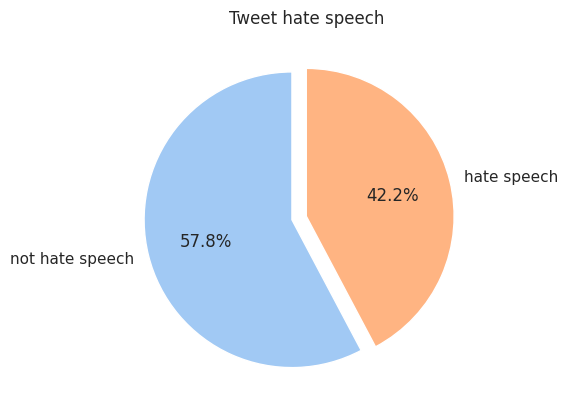

In [ ]:
hs = df_clean['HS'].value_counts()
hs.rename(index={0: "not hate speech",
                 1: "hate speech"},
          inplace=True)

colors = sns.color_palette('pastel')[0:5]

plt.pie(hs.values,
        labels = hs.index,
        colors = colors,
        autopct = '%1.1f%%',
        startangle = 90,
        explode = (0.1, 0))
plt.title('Tweet hate speech')
plt.show()

Text(0.5, 1.0, 'Category hate speech')

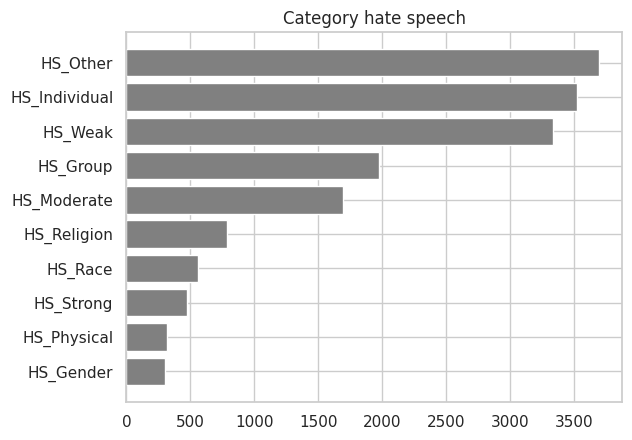

In [ ]:
hs_category = df.iloc[:, 3:].sum()

plt.barh(y = hs_category.sort_values().index,
         width = hs_category.sort_values().values,
         color = 'grey')
plt.title("Category hate speech")

### Word Freq

Merge all texts for each hate speech category

In [ ]:
hscat_text = dict()

for label in df_clean.columns[3:]:
  joined_text = str()
  for tweet in df_clean.loc[df_clean[label]==1]['Tweet']:
    joined_text += preprocess(tweet)
  hscat_text[label] = joined_text

Generate wordcloud

In [ ]:
wc_dict = dict()

for label in hscat_text:
  wc_dict[label] = WordCloud(
      background_color='white',
      max_words=2000
  )

  wc_dict[label].generate(hscat_text[label])

Wordcloud visualization

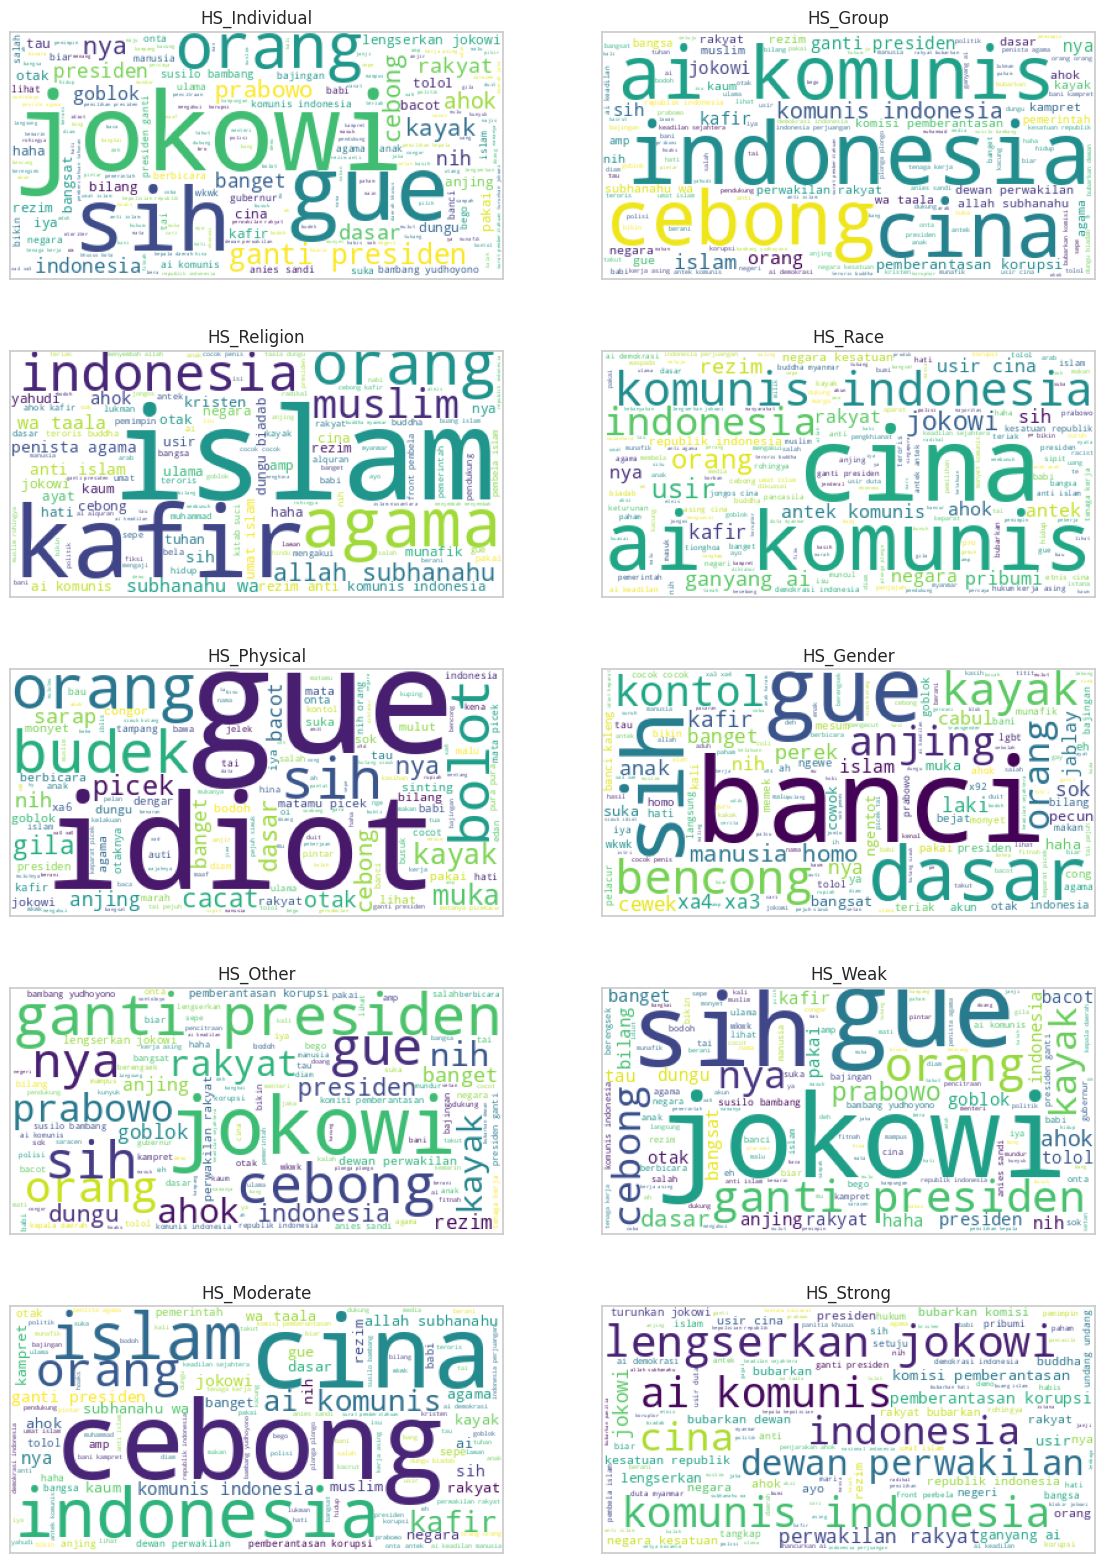

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(14,20))

for i, label in enumerate(df_clean.columns[3:]):
  row = int(i/2)
  col = i % 2

  ax[row, col].imshow(wc_dict[label])
  ax[row, col].set_title(label)
  ax[row, col].set_xticks([])
  ax[row, col].set_yticks([])

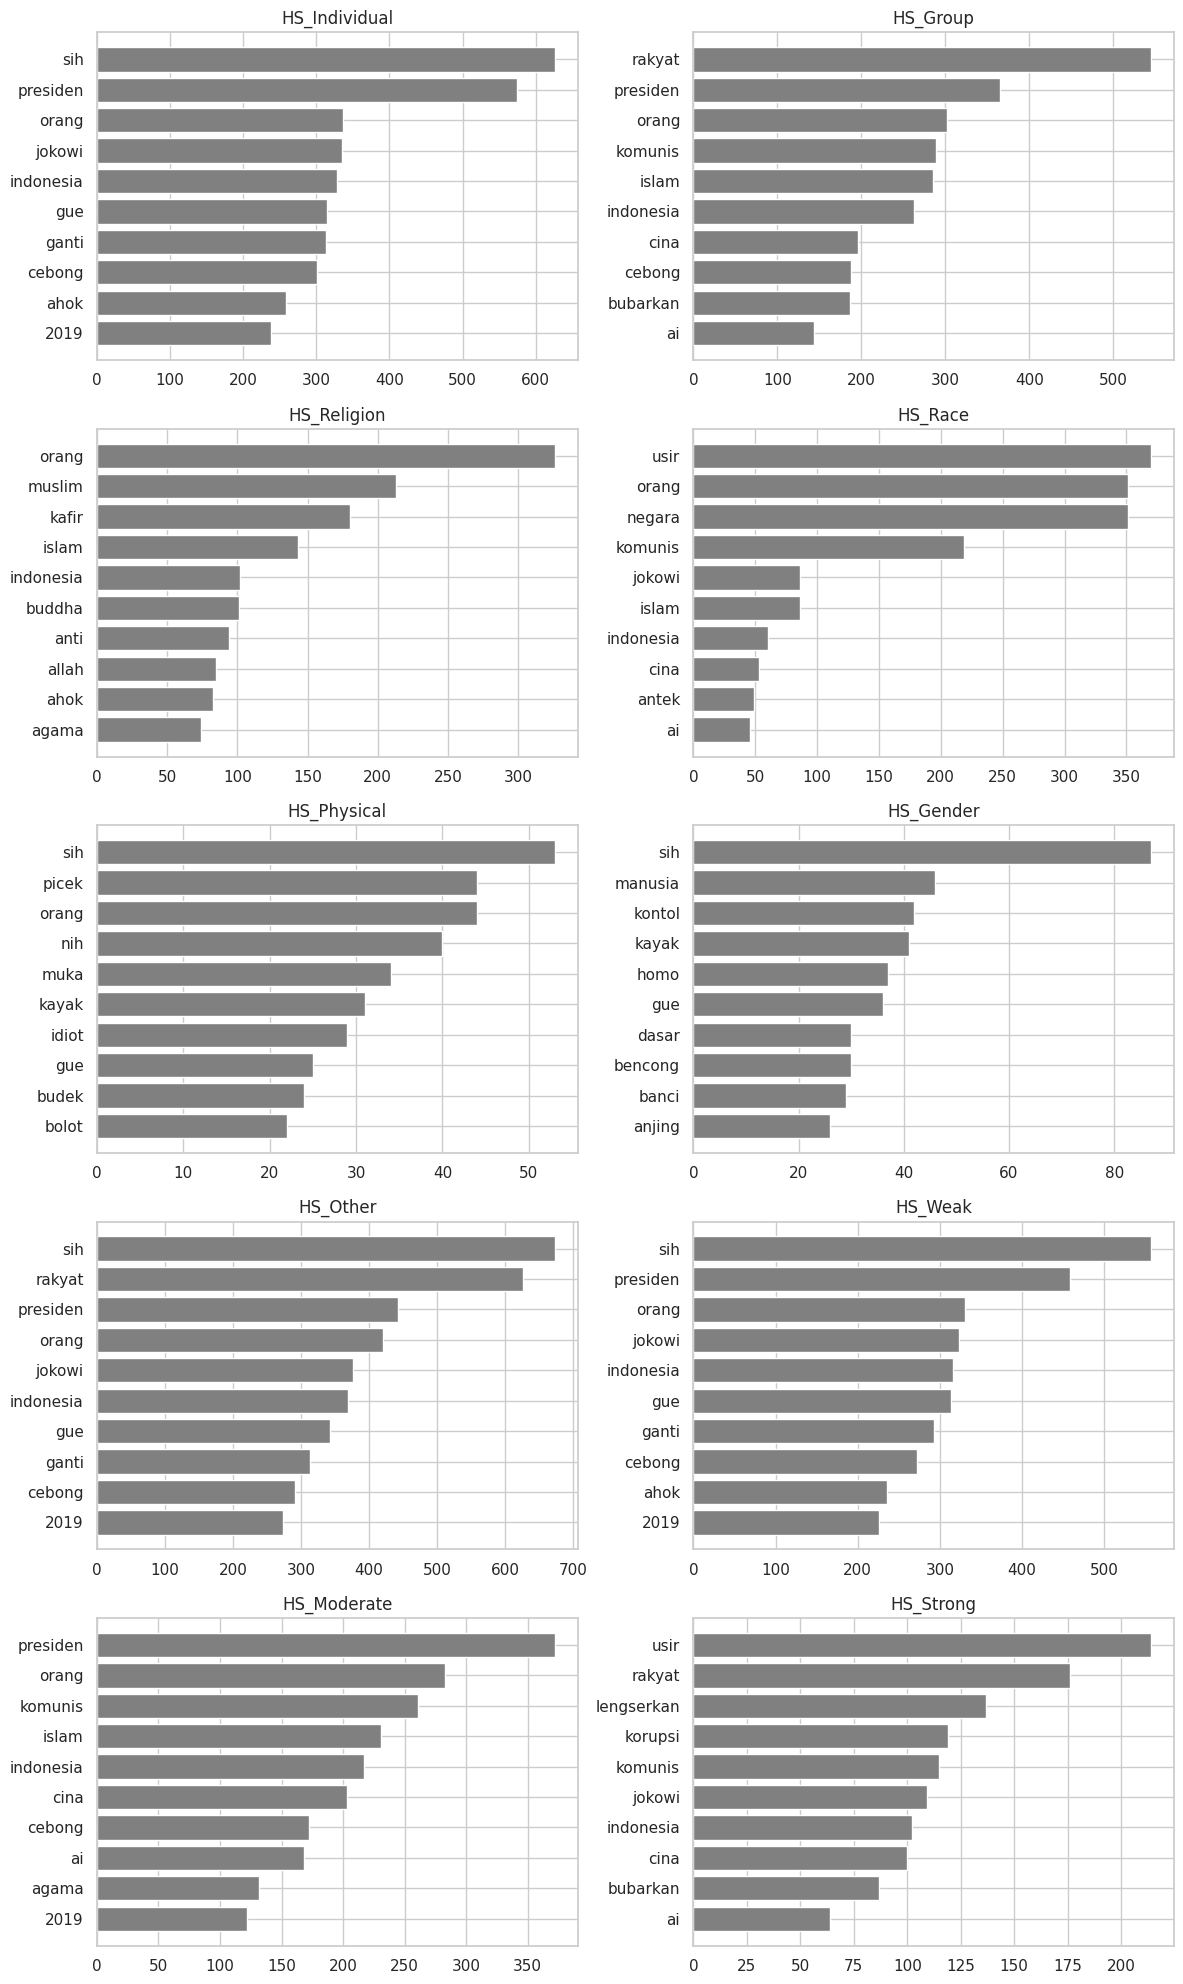

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(12,20))

for i, label in enumerate(hscat_text):
  freq_dist = nltk.FreqDist(nltk.tokenize.word_tokenize(hscat_text[label]))

  df_cat = pd.DataFrame(list(freq_dist.items()), columns=["Word", "Frequency"])
  df_cat = df_cat.sort_values(by=["Frequency"], ascending=False).head(10)

  row = int(i/2)
  col = i % 2

  ax[row, col].barh(y = sorted(df_cat['Word']),
                    width = sorted(df_cat['Frequency']),
                    color = 'grey')
  ax[row, col].set_title(label)

plt.tight_layout()

## Not Hate Speech

### Word Freq

Bifurcate text between hate speech text and non-hate speech text

In [ ]:
hscat_text = dict()

for label in [0, 1]:
  joined_text = str()
  for tweet in df_clean.loc[df_clean['HS']==label]['Tweet']:
    joined_text += preprocess(tweet)
  if label == 0:
    label = "Not HS"
  else:
    label = "HS"
  hscat_text[label] = joined_text

Generate word cloud

In [ ]:
wc_dict = dict()

for label in hscat_text:
  wc_dict[label] = WordCloud(
      background_color='white',
      max_words=2000
  )

  wc_dict[label].generate(hscat_text[label])

Word cloud visualization

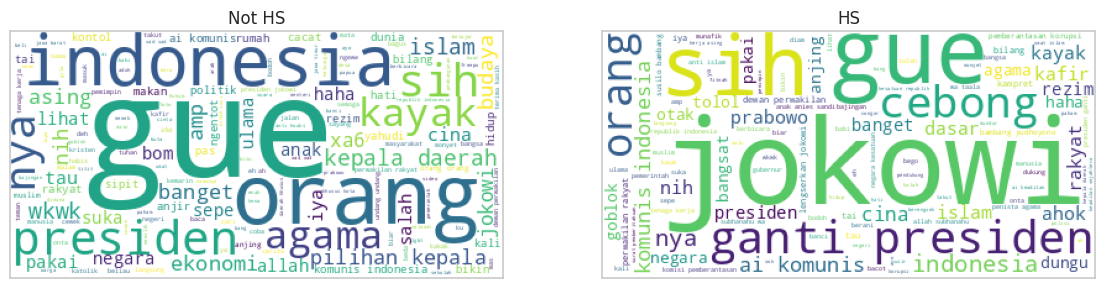

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,14))

for i, label in enumerate(hscat_text):
  ax[i].imshow(wc_dict[label])
  ax[i].set_title(label)
  ax[i].set_xticks([])
  ax[i].set_yticks([])

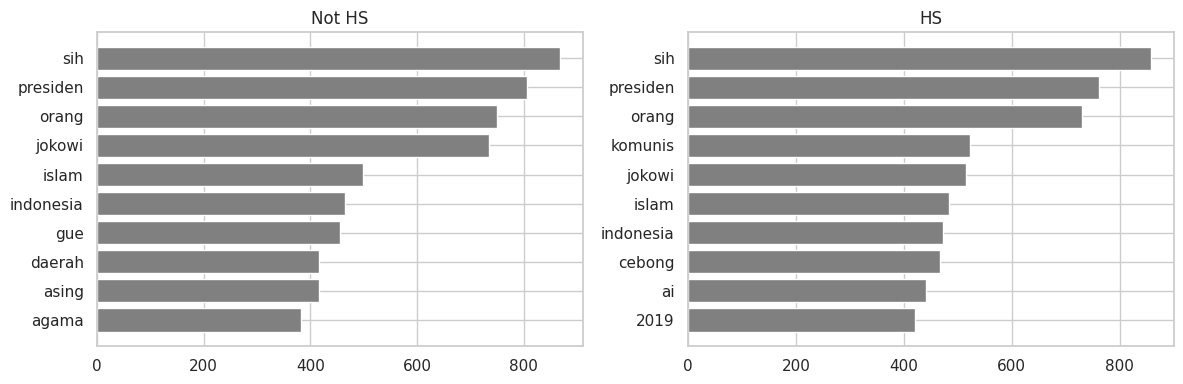

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

for i, label in enumerate(hscat_text):
  freq_dist = nltk.FreqDist(nltk.tokenize.word_tokenize(hscat_text[label]))
  df_cat = pd.DataFrame(list(freq_dist.items()), columns=["Word", "Frequency"])
  df_cat = df_cat.sort_values(by=["Frequency"], ascending=False).head(10)

  ax[i].barh(y = sorted(df_cat['Word']),
             width = sorted(df_cat['Frequency']),
             color = 'grey')
  ax[i].set_title(label)

plt.tight_layout()

## Abusive

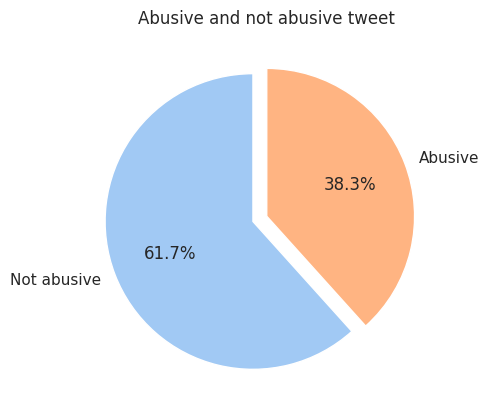

In [ ]:
abusive = df_clean['Abusive'].value_counts()
abusive.rename(index={0: "Not abusive",
                      1: "Abusive"},
               inplace=True)

plt.pie(abusive.values,
        labels = abusive.index,
        colors = colors,
        autopct = '%1.1f%%',
        startangle = 90,
        explode = (0.1, 0))
plt.title('Abusive and not abusive tweet')
plt.show()

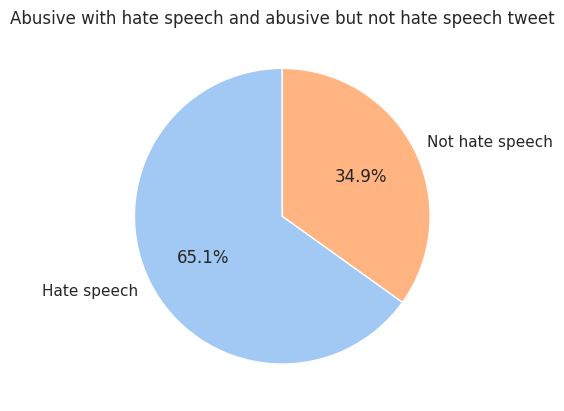

In [ ]:
abusive = df_clean[df_clean['Abusive'] == 1]['HS'].value_counts()
abusive.rename(index={0: "Not hate speech",
                      1: "Hate speech"},
               inplace=True)

plt.pie(abusive.values,
        labels = abusive.index,
        colors = colors,
        autopct = '%1.1f%%',
        startangle = 90)
plt.title('Abusive with hate speech and abusive but not hate speech tweet')
plt.show()

Text(0.5, 1.0, 'Abusive tweet')

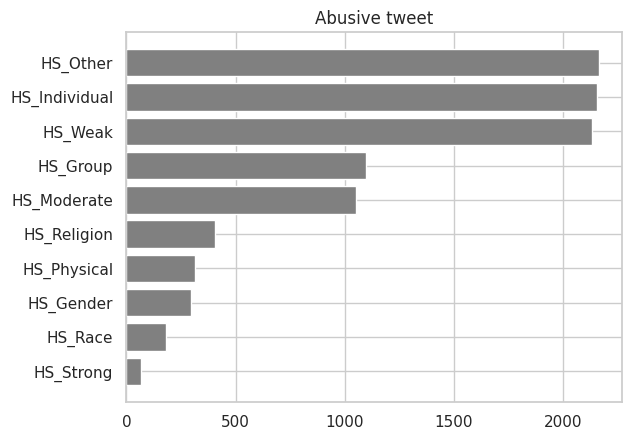

In [ ]:
abusive = df_clean[df_clean['Abusive'] == 1].iloc[:, 1:].sum().drop(['Abusive',
                                                                     'HS'])
plt.barh(y = abusive.sort_values().index,
         width = abusive.sort_values().values,
         color = 'grey')
plt.title('Abusive tweet')

### Word Freq

Merge text

In [ ]:
abusive_text = dict()

for label in [0, 1]:
  joined_text = str()
  for tweet in df_clean.loc[df_clean['Abusive']==label]['Tweet']:
    joined_text += preprocess(tweet)
  if label == 0:
    label = "Not Abusive"
  else:
    label = "Abusive"
  abusive_text[label] = joined_text

Generate word cloud

In [ ]:
wc_dict = dict()

for label in abusive_text:
  wc_dict[label] = WordCloud(
      background_color='white',
      max_words=2000
  )

  wc_dict[label].generate(abusive_text[label])

Word Cloud Visualization

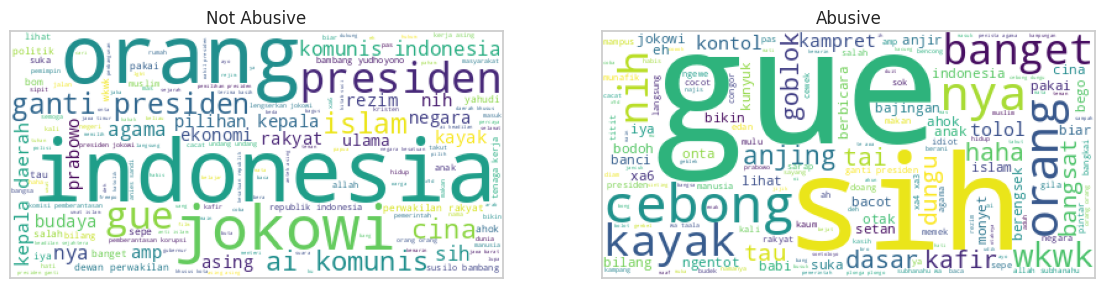

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,14))

for i, label in enumerate(abusive_text):
  ax[i].imshow(wc_dict[label])
  ax[i].set_title(label)
  ax[i].set_xticks([])
  ax[i].set_yticks([])

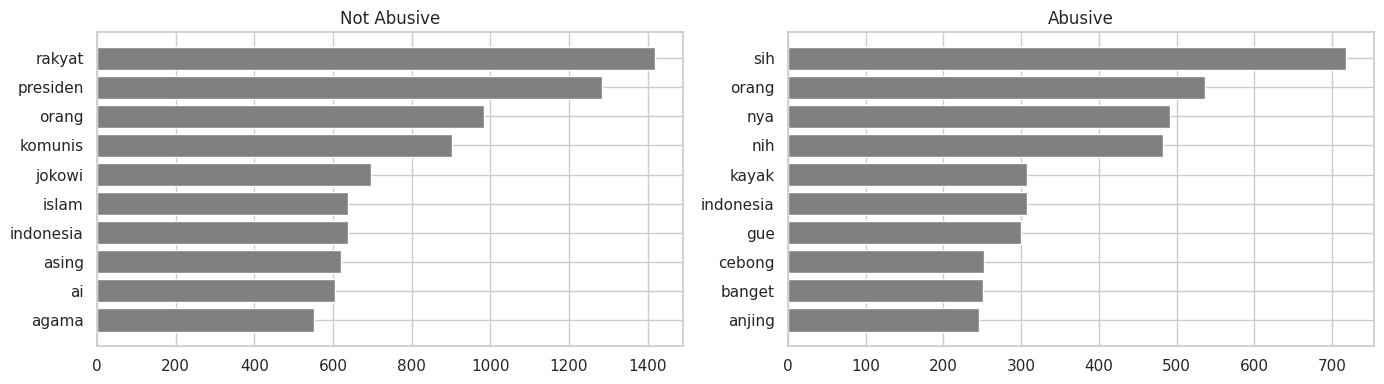

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))

for i, label in enumerate(abusive_text):
  freq_dist = nltk.FreqDist(nltk.tokenize.word_tokenize(abusive_text[label]))

  df_cat = pd.DataFrame(list(freq_dist.items()), columns=["Word", "Frequency"])
  df_cat = df_cat.sort_values(by=["Frequency"], ascending=False).head(10)

  ax[i].barh(y = sorted(df_cat['Word']),
             width = sorted(df_cat['Frequency']),
             color = 'grey')
  ax[i].set_title(label)

plt.tight_layout()

## Correlation

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'HS_Individual'),
  Text(1.5, 0, 'HS_Group'),
  Text(2.5, 0, 'HS_Religion'),
  Text(3.5, 0, 'HS_Race'),
  Text(4.5, 0, 'HS_Physical'),
  Text(5.5, 0, 'HS_Gender'),
  Text(6.5, 0, 'HS_Weak'),
  Text(7.5, 0, 'HS_Moderate'),
  Text(8.5, 0, 'HS_Strong')])

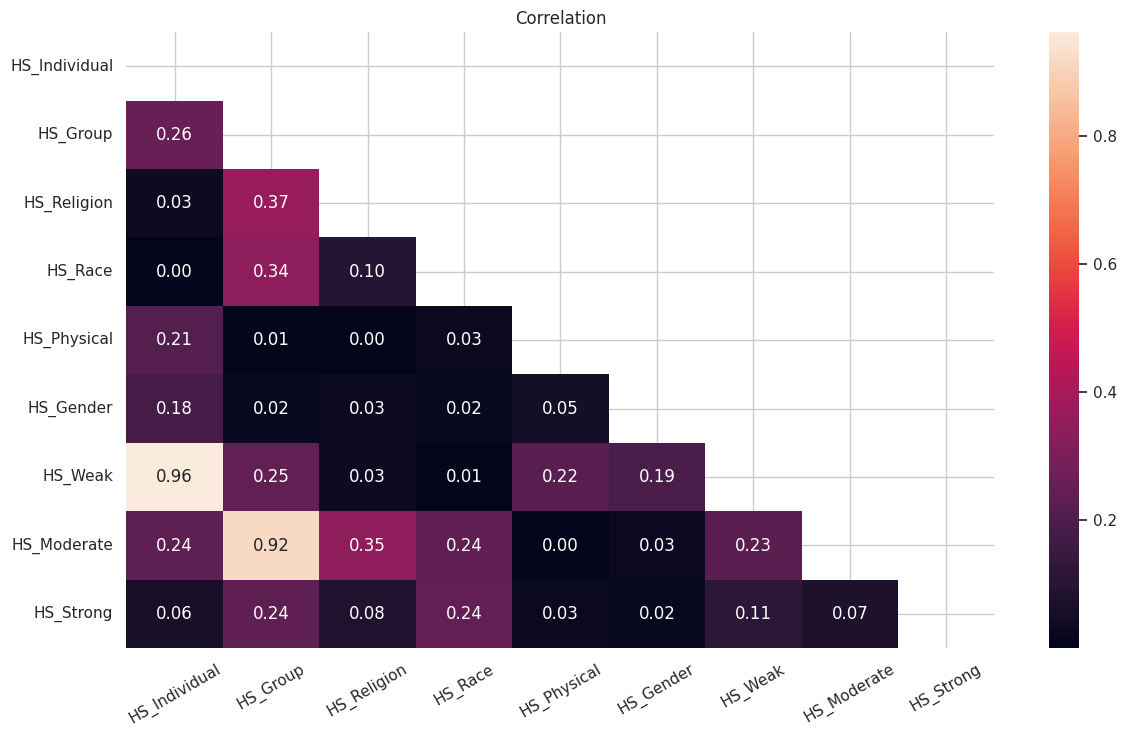

In [ ]:
corr = df_clean.drop(['Tweet', 'HS', 'Abusive', 'HS_Other'],
                     axis=1).corr().abs()
mask = np.triu(corr)

plt.figure(figsize=(14,8))
sns.heatmap(corr, annot=True, mask=mask, fmt='.2f')
plt.title("Correlation")
plt.xticks(rotation=30)

# Sentiment Analysis

## Label Preparation

In [ ]:
df_sentiment = df_clean.copy().drop(df_clean.columns[3:],
                                    axis = 1)

def sentiment(hs, abusive):
  if (hs == 1) and (abusive == 1):
    return 'HS_Abusive'
  elif (hs == 1) and (abusive == 0):
    return 'HS_NotAbusive'
  elif (hs == 0) and (abusive == 1):
    return 'NotHS_Abusive'
  else:
    return 'NotHS_NotAbusive'

df_sentiment['sentiment'] = df_sentiment.apply(lambda x: sentiment(x['HS'],
                                                                   x['Abusive']),
                                               axis=1)

df_sentiment.drop(['HS', 'Abusive'], axis=1, inplace=True)

df_sentiment.head()

,Tweet,sentiment
0,cowok berusaha melacak perhatian gue lantas r...,HS_Abusive
1,telat tau edan sarap gue bergaul cigax jifla ...,NotHS_Abusive
2,41 kadang berpikir percaya tuhan jatuh berkal...,NotHS_NotAbusive
3,ku tau matamu sipit,NotHS_NotAbusive
4,kaum cebong kafir dongoknya dungu haha,HS_Abusive


In [ ]:
df_label = pd.get_dummies(df_sentiment['sentiment'])
df_sentiment.drop('sentiment', axis=1, inplace=True)
df_sentiment = pd.concat([df_sentiment['Tweet'], df_label], axis=1)

df_sentiment.head()

,Tweet,HS_Abusive,HS_NotAbusive,NotHS_Abusive,NotHS_NotAbusive
0,cowok berusaha melacak perhatian gue lantas r...,True,False,False,False
1,telat tau edan sarap gue bergaul cigax jifla ...,False,False,True,False
2,41 kadang berpikir percaya tuhan jatuh berkal...,False,False,False,True
3,ku tau matamu sipit,False,False,False,True
4,kaum cebong kafir dongoknya dungu haha,True,False,False,False


<Axes: title={'center': 'Number of tweets per category'}>

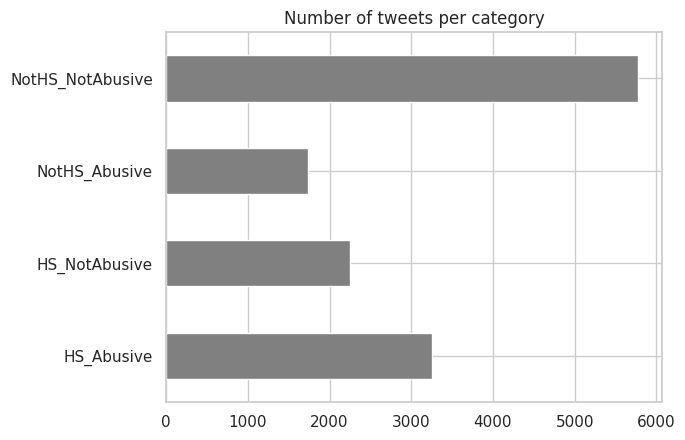

In [ ]:
df_sentiment.sum()[1:].plot(kind='barh', color='grey',
                            title='Number of tweets per category')

In [ ]:
tweet = df_sentiment['Tweet'].values
labels = df_sentiment.iloc[:, 1:].values

print(">>> Teks:")
print(tweet[:2])
print()
print(">>> Label:")
print(labels[:2])

>>> Teks:
[' cowok berusaha melacak perhatian gue lantas remehkan perhatian gue kasih khusus basic cowok bego'
 ' telat tau edan sarap gue bergaul cigax jifla calis licew']

>>> Label:
[[ True False False False]
 [False False  True False]]


In [ ]:
labels_list = df_sentiment.columns[1:]
labels_list

Index(['HS_Abusive', 'HS_NotAbusive', 'NotHS_Abusive', 'NotHS_NotAbusive'], dtype='object')

## Data Splitting

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(tweet,
                                                  labels,
                                                  test_size=0.3,
                                                  random_state=45)

x_val, x_test, y_val, y_test = train_test_split(x_val, y_val,
                                                test_size=0.5,
                                                random_state=53)

## Tokenizing

Transforming text data that was originally in the form of sentences into fragments of words or tokens.

* The maximum vocabulary taken for tokenizing is 15000 based on the most frequently occurring words.
* The maximum array length in one data is set to 1000.
* If the number of words in a data is less than 1000 words, then in the tokenized array, the remaining value at the end will be set to 0.

In [ ]:
NUM_WORDS = 10000

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token='')

tokenizer.fit_on_texts(x_train)

seq_train = tokenizer.texts_to_sequences(x_train)
seq_val = tokenizer.texts_to_sequences(x_val)
seq_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(seq_train, padding='post',
                        maxlen=1000, truncating='post')
x_val = pad_sequences(seq_val, padding='post',
                      maxlen=1000, truncating='post')
x_test = pad_sequences(seq_test, padding='post',
                       maxlen=1000, truncating='post')

print(len(tokenizer.word_index))
print(x_train.max())
print(len(x_val[0]))

16209
9999
1000


Simpan tokenizer

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Result/tokenizer.pickle',
          'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Modelling

The model to be used is Bidirectional GRU with the following configuration:

* 1 BiGRU Layer with number of hidden states 32 and dropout 0.5
* 1 Dense Layer with number of hidden states 16 and l2 regularization 0.5 and relu activation function
* 1 Dropout Layer 0,5
* Output Layer with softmax activation function
* Optimizer Adam
* Learning rate = 0,001
* Epochs = 45,  but if the validation accuracy has reached more than 90%, the training process will stop immediately.
* Batch size = 256

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
highest_acc_train = [0,0]
highest_acc_test = [0,0]

class myCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        global highest_acc_train, highest_acc_test

        target_acc = 0.9

        if logs.get('acc') > target_acc and logs.get('val_acc') > target_acc:
            print("\nThe accuracy has reached >", target_acc)
            self.model.stop_training = True
        if logs.get('acc') > highest_acc_train[0]:
            highest_acc_train[0] = logs.get('acc')
            highest_acc_train[1] = epoch+1
        if logs.get('val_acc') > highest_acc_test[0]:
            highest_acc_test[0] = logs.get('val_acc')
            highest_acc_test[1] = epoch+1

early_stopping = keras.callbacks.EarlyStopping(patience=5,
                                               monitor='val_loss',
                                               min_delta=0.01,
                                               verbose=1)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1)

callbacks = myCallback()

model = models.Sequential([
    layers.Embedding(input_dim=NUM_WORDS, output_dim=16),
    layers.Bidirectional(layers.LSTM(32, dropout=0.5)),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(labels_list), activation='softmax')
])

# model.summary()

model.compile(loss=losses.CategoricalCrossentropy(),
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

hist = model.fit(x_train, y_train,
                 epochs=45,
                 batch_size=256,
                 validation_data=(x_val, y_val),
                 validation_steps=5,
                 verbose=2,
                 callbacks=[callbacks, early_stopping,
                            tensorboard_callback])

print("\nHighest training accuracy: %.4f | epoch: %i"%(highest_acc_train[0],
                                                       highest_acc_train[1]))
print("Highest validation accuracy: %.4f | epoch: %i"%(highest_acc_test[0],
                                                       highest_acc_test[1]))

Epoch 1/45
36/36 - 16s - loss: 1.3251 - acc: 0.4093 - val_loss: 1.2881 - val_acc: 0.4281 - 16s/epoch - 447ms/step
Epoch 2/45
36/36 - 6s - loss: 1.2752 - acc: 0.4408 - val_loss: 1.2290 - val_acc: 0.4281 - 6s/epoch - 175ms/step
Epoch 3/45
36/36 - 7s - loss: 1.1646 - acc: 0.4642 - val_loss: 1.1107 - val_acc: 0.4680 - 7s/epoch - 183ms/step
Epoch 4/45
36/36 - 5s - loss: 1.0259 - acc: 0.5582 - val_loss: 1.0012 - val_acc: 0.5781 - 5s/epoch - 135ms/step
Epoch 5/45
36/36 - 6s - loss: 0.9012 - acc: 0.6231 - val_loss: 0.9291 - val_acc: 0.6453 - 6s/epoch - 162ms/step
Epoch 6/45
36/36 - 4s - loss: 0.8004 - acc: 0.6781 - val_loss: 0.8672 - val_acc: 0.6891 - 4s/epoch - 116ms/step
Epoch 7/45
36/36 - 4s - loss: 0.7073 - acc: 0.7146 - val_loss: 0.8291 - val_acc: 0.6891 - 4s/epoch - 102ms/step
Epoch 8/45
36/36 - 5s - loss: 0.6331 - acc: 0.7586 - val_loss: 0.8043 - val_acc: 0.7164 - 5s/epoch - 132ms/step
Epoch 9/45
36/36 - 4s - loss: 0.5796 - acc: 0.7882 - val_loss: 0.7705 - val_acc: 0.7352 - 4s/epoch - 1

In [ ]:
%tensorboard --logdir logs/fit

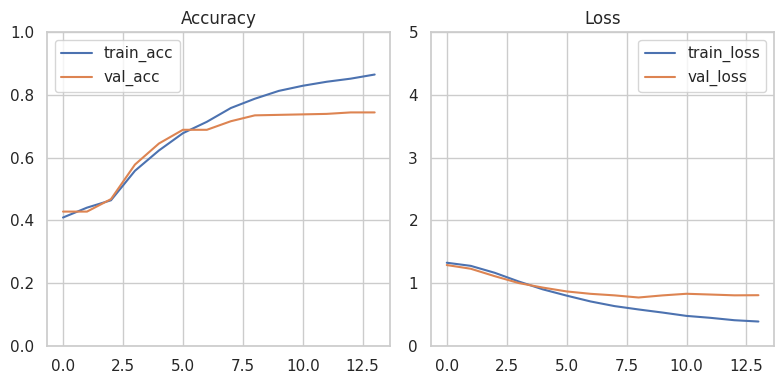

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))

ax[0].plot(hist.history['acc'], label = 'train_acc')
ax[0].plot(hist.history['val_acc'], label = 'val_acc')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_ylim(0, 1)

ax[1].plot(hist.history['loss'], label = 'train_loss')
ax[1].plot(hist.history['val_loss'], label = 'val_loss')
ax[1].legend()
ax[1].set_title('Loss')
#ax[1].set_ylim([0,max(hist.history['loss'] + hist.history['val_loss'])])
ax[1].set_ylim([0,5])

fig.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

# model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Result/model.h5')

# Perform prediction on test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert prediction results into class labels

# Collecting the actual label of the test data
y_true = np.argmax(y_test, axis=1)

# Calculating confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

62/62 [==============================] - 2s 24ms/step
[[365  34  42  55]
 [ 13 259   3  82]
 [ 58   3 157  47]
 [ 40  54  19 723]]


Index(['HS_Abusive', 'HS_NotAbusive', 'NotHS_Abusive', 'NotHS_NotAbusive'], dtype='object')


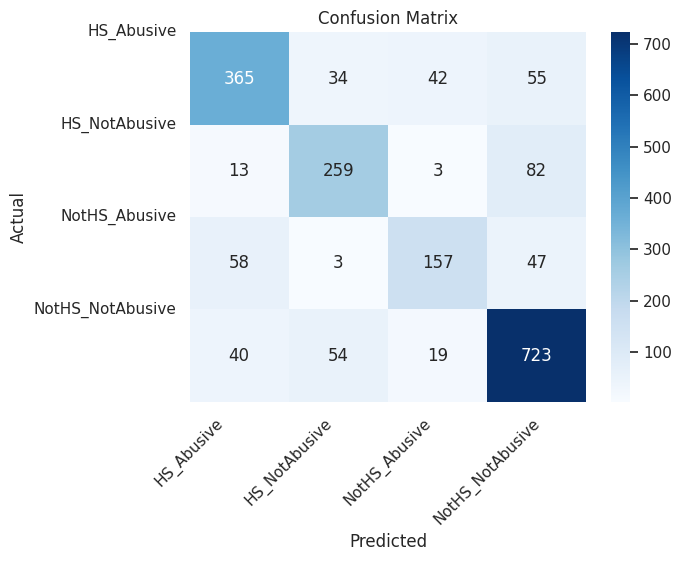

In [ ]:
print(labels_list)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(range(4), labels_list, rotation=45)
plt.yticks(range(4), labels_list, rotation=0)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_true, y_pred))

print(labels_list)

print(accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.74      0.75       496
           1       0.74      0.73      0.73       357
           2       0.71      0.59      0.65       265
           3       0.80      0.86      0.83       836

    accuracy                           0.77      1954
   macro avg       0.75      0.73      0.74      1954
weighted avg       0.77      0.77      0.77      1954

Index(['HS_Abusive', 'HS_NotAbusive', 'NotHS_Abusive', 'NotHS_NotAbusive'], dtype='object')
0.7697031729785057


## Saved Model

In [ ]:
!pip install tensorflowjs

model.save("/content/drive/MyDrive/Colab Notebooks/Result/model.h5")

!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 32.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2024-06-18 06:19:36.287718: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 963, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 949, in convert
    _dispatch_converter(input_format, output_format, args, quantization_dtype_map,
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 619, in _dispatch_converter
    dispatch_keras_h5_to_tfjs_layers_model_conversion(
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 78, in di

# Let's Play

## Package Prepraration

In [ ]:
!pip install Sastrawi

import string
import re
import pickle

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

alay_df = pd.read_csv('/content/new_kamusalay.csv',
                        encoding = 'latin-1',
                        header = None)

alay_df.rename(columns={0: 'original',
                        1: 'replacement'},
               inplace = True)

alay_dict_map = dict(zip(alay_df['original'], alay_df['replacement']))

def normalize_alay(text):
  return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def convert_lower_case(text):
  return text.lower()

def remove_stop_words(text):
  stop_words = stopwords.words('indonesian')
  words = word_tokenize(str(text))
  new_text = ""
  for w in words:
    if w not in stop_words and len(w) > 1:
      new_text = new_text + " " + w
  return new_text

def remove_unnecessary_char(text):
  text = re.sub('\n',' ',text) # Remove every '\n'
  text = re.sub('rt',' ',text) # Remove every retweet symbol
  text = re.sub('user',' ',text) # Remove every username
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
  text = re.sub('  +', ' ', text) # Remove extra spaces

  text = re.sub('x9f', ' ', text)
  text = re.sub('x98', ' ', text)
  text = re.sub('xf0', ' ', text)

  text = re.sub(' ya ', ' ', text)
  text = re.sub('x82', ' ', text)
  text = re.sub('uniform', ' ', text)
  text = re.sub('resource', ' ', text)

  text = re.sub('xe2', ' ', text)
  text = re.sub('x80', ' ', text)
  text = re.sub('x91', ' ', text)
  text = re.sub('x8c', ' ', text)

  text = re.sub('locator', ' ', text)
  return text

def remove_punctuation(text):
  symbols = string.punctuation
  for i in range(len(symbols)):
    text = text.replace(symbols[i], ' ')
    text = text.replace("  ", " ")
  text = text.replace(',', '')
  return text

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()

  tokens = word_tokenize(str(text))
  new_text = ""
  for w in tokens:
    new_text = new_text + " " + stemmer.stem(w)
  return new_text

counter = 0

def preprocess(text, verbose=0):
  global counter

  text = convert_lower_case(text)
  text = remove_unnecessary_char(text)
  text = remove_punctuation(text)
  text = remove_stop_words(text)
  text = normalize_alay(text)
  # text = stemming(text)
  text = remove_stop_words(text)
  text = remove_punctuation(text)

  counter += 1
  if (counter % 10 == 0) and (verbose == 1):
    print(f"\r{counter}", end="")
  return text

with open('/content/drive/MyDrive/Colab Notebooks/tokenizer.pickle',
          'rb') as handle:
    tokenizer = pickle.load(handle)

model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Result/model.h5')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Write a tweet

In [ ]:
whats_happening = 'Dasar kau bodoh sekali ya' #@param {type: 'string'}

preprocess_tweet = preprocess(whats_happening, verbose=0)

seq_tweet = tokenizer.texts_to_sequences([preprocess_tweet])

the_tweet = pad_sequences(seq_tweet, padding='post',
                          maxlen=1000, truncating='post')

prediction = model.predict(the_tweet, verbose=0)

classes = np.argmax(prediction, axis = 1)

dict_classes = {
    0: 'VERY NEGATIVE. Hate Speech and Abusive Tweet',
    1: 'NEGATIVE. Hate Speech but NOT Abusive Tweet',
    2: 'NETRAL. NOT Hate Speech but Abusive Tweet',
    3: 'POSITIVE. NOT Hate Speech and NOT Abusive Tweet'
}

print('\n\"' + whats_happening + '\"\n')
print("This tweet is:\n   ", dict_classes[classes[0]])


"Dasar kau bodoh sekali ya"

This tweet is:
    VERY NEGATIVE. Hate Speech and Abusive Tweet
